# Initialize

In [1]:
import os
import sys
import csv, json
import math, random, ast, swifter
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import portion as P
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pprint import pprint
from collections import namedtuple

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

## Basic Functions

In [2]:
def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = ['seq', 'rpkg', 'frame_id', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time']
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['latency']] = df[['latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

## Parse Handover

In [3]:
triggered_events = {
    'HO':     ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II', ],
    'RLF':    ['MCGF', 'NASR', 'SCGF', ],
    'Others': ['CXNS', 'CXNR', 'SCLA', ],
}

rlf_events = {
    'MCGF': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)', ],
    'NASR': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)', ],
    'SCGF': ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)', ],
}

In [4]:
def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    nr_arfcn = 0
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | ({nr_pci}, {nr_arfcn})'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
            nr_pci = int(df['nr_physCellId'].iloc[i])
            nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

In [5]:
def mi_parse_handover(df, tz=8, radical=True, endfill=False):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)
    
    if table.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Handover Not Found!!!')
        return table, new_D
    
    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label (PCI, BSID)
    # table[['eNB_ID', 'next_eNB_ID',]] = table[['eNB_ID', 'next_eNB_ID']].astype('Int64')
    table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']] = \
        table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']].astype('Int64')
    
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    for col in ['m_src', 's_src']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    for col in ['m_tgt', 's_tgt']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna() & table['next_eNB_ID'].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['next_eNB_ID'].astype(str)
        filtered_table2 = table[table[col].notna() & table['next_eNB_ID'].isna()].copy()
        filtered_table2[new_col] = filtered_table2[col].astype(str) + ', ' + filtered_table2['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1, filtered_table2], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # find row na-"end" & fill with "start"
    if endfill:
        nan_end_rows = table[table['end'].isnull()]
        table.loc[nan_end_rows.index, 'end'] = nan_end_rows['start']
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

## Handover Labelings

In [6]:
def handover_classify_labelling(df_ho, df_dl=None, df_ul=None, ratio=0.5, scope=None):
    
    if scope is None:
        scope = {
            'LTEH': (-4.0, 2.0, 0.018),
            'ENBH': (-4.0, 2.6, 0.019),
            'MCGH': (-3.0, 3.3, 0.019),
            'MNBH': (-3.2, 3.3, 0.02),
            'SCGM': (-4.2, 3.3, 0.017),
            'SCGA': (-1.2, 2.6, 0.027),
            'SCGR-I': (-3.1, 3.3, 0.04),
            'SCGC-I': (-3.0, 2.9, 0.37),
            'SCGR-II': (-2.0, 4.1, 0.034),
            'SCGC-II': (-2.0, 3.2, 0.396),
            'MCGF': (-5.8, 7.2, 0.078),
            'NASR': (-4.0, 6.5, 0.394),
            'SCGF': (-4.0, 4.6, 0.111)
        }
        
    def interp(x, y, ratio):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio

    Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
    Duration = namedtuple('Duration', ['total', 'stable', 'unstable'])

    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    E = { stage: { key: [] for key in [*scope.keys(), *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after']}
    E['overview'] = {}

    selected_cols = ['stage', 'category', 'type', 'cause', 'index', 'inter-RAT', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng']
    reset_values = ['-', 'stable', 'stable', '-', -1, False, False, False, False, False]
    
    dl_start_time, dl_end_time = pd.Timestamp.max, pd.Timestamp.min
    if df_dl is not None:
        dl_start_time, dl_end_time = df_dl.iloc[0]['Timestamp'] - pd.Timedelta(seconds=0.1), df_dl.iloc[-1]['Timestamp'] + pd.Timedelta(seconds=0.1)
        # df_dl = df_dl.reindex(columns=[*list(df_dl.columns), *selected_cols])
        # Reset the specified columns using a loop
        for col, reset_value in zip(selected_cols, reset_values):
            df_dl[col] = reset_value
    
    ul_start_time, ul_end_time = pd.Timestamp.max, pd.Timestamp.min
    if df_ul is not None:
        ul_start_time, ul_end_time = df_ul.iloc[0]['Timestamp'] - pd.Timedelta(seconds=0.1), df_ul.iloc[-1]['Timestamp'] + pd.Timedelta(seconds=0.1)
        # df_ul = df_ul.reindex(columns=[*list(df_ul.columns), *selected_cols])
        # Reset the specified columns using a loop
        for col, reset_value in zip(selected_cols, reset_values):
            df_ul[col] = reset_value
            
    start_time, end_time = min(dl_start_time, ul_start_time), max(dl_end_time, ul_end_time)
    stable_interval = P.open(start_time, end_time)
    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row['type']  # specific column name
        cause = row['cause']
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        ho_info = [row['category'], row['type'], row['cause'], i, row['inter-RAT'], row['inter-eNB'], row['inter-gNB'], row['inter-Freq'], row['band_cng']]
        
        # peri_interval
        if pd.isna(row.end):
            peri_interval = P.singleton(row.start)
        else:
            peri_interval = P.closed(row.start, row.end)

        # prior_interval
        C = row.start + pd.Timedelta(seconds=scope[tag][0])
        D = row.start
        prior_interval = P.closedopen(C, D)
        if ratio is not None and i != 0:
            prior_tag = prior_row['type']
            A = max(prior_row.start, prior_row.end)
            B = max(prior_row.start, prior_row.end) + pd.Timedelta(seconds=scope[prior_tag][1]-scope[prior_tag][2])
            if P.openclosed(A, B).overlaps(prior_interval):
                # print("Overlaps with the previous!")
                bkp = interp(C, B, ratio)
                bkp = max(bkp, A)  # avoid the breakpoint overlapping the previous event's duration
                # bkp = min(max(bkp, A), D)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！可不加！
                prior_interval = P.closedopen(bkp, D)
                if A in prior_interval:
                    prior_interval = P.open(bkp, D)
        
        # post_interval
        C = row.end
        D = row.end + pd.Timedelta(seconds=scope[tag][1]-scope[tag][2])
        post_interval = P.openclosed(C, D)
        if ratio is not None and i != len(df_ho)-1:
            post_tag = post_row['type']
            A = min(post_row.start, post_row.end) + pd.Timedelta(seconds=scope[post_tag][0])
            B = min(post_row.start, post_row.end)
            if P.closedopen(A, B).overlaps(post_interval):
                # print("Overlaps with the following!")
                bkp = interp(A, D, ratio)
                bkp = min(bkp, B)  # avoid the breakpoint overlappint the following event's duration
                # bkp = max(min(bkp, B), C)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！可不加！
                post_interval = P.open(C, bkp)
        
        # calculate lost & excl
        dl_pkt, dl_lost, dl_excl = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        if df_dl is not None:
            for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
                if intv.empty:
                    continue
                # filt = (df_dl['arr_time'] >= intv.lower) & (df_dl['arr_time'] < intv.upper)
                filt = (df_dl['Timestamp'] >= intv.lower) & (df_dl['Timestamp'] < intv.upper)
                tmp = df_dl[filt].copy()
                dl_pkt[i] = len(tmp)
                dl_lost[i] = sum(tmp['lost'])
                dl_excl[i] = sum(~tmp['lost'] & tmp['excl'])
                df_dl.loc[filt, selected_cols] = [stage, *ho_info]
        
        ul_pkt, ul_lost, ul_excl = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        if df_ul is not None:
            for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
                if intv.empty:
                    continue
                # filt = (df_ul['xmit_time'] >= intv.lower) & (df_ul['xmit_time'] < intv.upper)
                filt = (df_dl['Timestamp'] >= intv.lower) & (df_dl['Timestamp'] < intv.upper)
                tmp = df_ul[filt].copy()
                ul_pkt[i] = len(tmp)
                ul_lost[i] = sum(tmp['lost'])
                ul_excl[i] = sum(~tmp['lost'] & tmp['excl'])
                df_ul.loc[filt, selected_cols] = [stage, *ho_info]
        
        # fill in the blank
        for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
            E[stage][tag].append((intv, Metrics(dl_pkt[i], dl_lost[i], dl_excl[i], ul_pkt[i], ul_lost[i], ul_excl[i])))
            if tag in ['MCGF', 'NASR', 'SCGF']:
                E[stage][f'{tag}_{cause}'].append((intv, Metrics(dl_pkt[i], dl_lost[i], dl_excl[i], ul_pkt[i], ul_lost[i], ul_excl[i])))
        
        # update stable interval
        stable_interval = stable_interval - prior_interval - peri_interval - post_interval
    
    stable_dl_pkt, stable_dl_lost, stable_dl_excl = 0, 0, 0
    stable_ul_pkt, stable_ul_lost, stable_ul_excl = 0, 0, 0
    if df_dl is not None:
        tmp = df_dl[df_dl['category'] == 'stable'].copy()
        stable_dl_pkt = len(tmp)
        stable_dl_lost = sum(tmp['lost'])
        stable_dl_excl = sum(~tmp['lost'] & tmp['excl'])
    
    if df_ul is not None:
        tmp = df_ul[df_ul['category'] == 'stable'].copy()
        stable_ul_pkt = len(tmp)
        stable_ul_lost = sum(tmp['lost'])
        stable_ul_excl = sum(~tmp['lost'] & tmp['excl'])
    
    total_duration = (end_time - start_time).total_seconds()
    stable_duration = 0
    for intv in stable_interval:
        if intv.empty:
            continue
        stable_duration += (intv.upper - intv.lower).total_seconds()
    unstable_duration = total_duration - stable_duration
    
    E['overview']['stable_intv'] = (stable_interval, Metrics(stable_dl_pkt, stable_dl_lost, stable_dl_excl, stable_ul_pkt, stable_ul_lost, stable_ul_excl))
    E['overview']['duration'] = Duration(total_duration, stable_duration, unstable_duration)

    return E, df_dl, df_ul

In [7]:
def metrics_duration_into_dict(E):
    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    A = { stage: { key: [] for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
                                    'MCGF', 'NASR', 'SCGF', *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after'] }
    A['overview'] = {}

    for stage in ['before', 'during', 'after']:
        for tag, lst in E[stage].items():
            for item in lst:
                A[stage][tag].append((item[0], item[1]._asdict()))
    A['overview']['stable_intv'] = (E['overview']['stable_intv'][0], E['overview']['stable_intv'][1]._asdict())
    A['overview']['duration'] = E['overview']['duration']._asdict()
    
    return A

def dict_into_metrics_duration(A):
    Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
    Duration = namedtuple('Duration', ['total', 'stable', 'unstable'])

    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    B = { stage: { key: [] for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
                                    'MCGF', 'NASR', 'SCGF', *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after'] }
    B['overview'] = {}

    for stage in ['before', 'during', 'after']:
        for tag, lst in A[stage].items():
            for item in lst:
                B[stage][tag].append((item[0], Metrics(**item[1])))
    B['overview']['stable_intv'] = (A['overview']['stable_intv'][0], Metrics(**A['overview']['stable_intv'][1]))
    B['overview']['duration'] = Duration(**A['overview']['duration'])
    
    return B

In [8]:
def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def interp(x, y, ratio):
    """
    Interpolation (線性內插法)

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

# Setup Profile: Functions

In [9]:
def setup_profile_instance(df, tag, start, end, scope, ts_col='Timestamp', w_size=0.01,
                           mode='dl', mets='lost', left_bd=pd.Timestamp.min, right_bd=pd.Timestamp.max):
    
    # Centered at start timestamp of each handover event
    intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left_bd), min(start+pd.Timedelta(seconds=scope[tag][1]), right_bd))
    
    # Relative window from timestamp
    df_plot = df[(df[ts_col] >= intv.lower) & (df[ts_col] < intv.upper)].copy().reset_index(drop=True)
    df_plot['rel_time'] = (df_plot['Timestamp'] - start).dt.total_seconds()
    
    # 四捨五入
    df_plot['cat_id'] = ((df_plot['rel_time'] + w_size / 2) // w_size) * w_size
    
    if mets == 'lost':
        # Calculate PLR
        ts_group = df_plot.groupby(['cat_id'])
        table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
        table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
        table['PLR'] = table['PLR'] * 100
    elif mets == 'excl':
        # Calculate ELR
        df_plot['excl_new'] = df_plot['excl'] & ~df_plot['lost']
        ts_group = df_plot.groupby(['cat_id'])
        table = ts_group['excl_new'].agg(['count','sum','mean']).copy().reset_index()
        table = table.rename(columns={'count':'tx_count', 'sum':'excl', 'mean':'ELR'})
        table['ELR'] = table['ELR'] * 100
    
    return table, intv

In [10]:
def setup_profile(df, df_ho, mode='dl', mets='lost', sp_col=None, scope=None, ts_col='Timestamp'):
    # Initialize
    A = {tag: {'tables': [], 'intrs': [], 'triggered': []} for tag in scope.keys()}
    stable_intv = P.open(pd.Timestamp.min, pd.Timestamp.max)
    stable_pkt = 0
    stable_miss = 0
    stable_miss_rate = 0

    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row[sp_col]  # specific column name
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        
        # Set left/right bounds to avoid event overlapping with each other
        if prior_row is not None:
            if pd.notna(prior_row['end']):
                left = prior_row['end'] + (start - prior_row['end']) / 2
            else:
                left = prior_row['start'] + (start - prior_row['start']) / 2
        else:
            left = pd.Timestamp.min
        if post_row is not None:
            if pd.notna(end):
                right = end + (post_row['start'] - end) / 2
            else:
                right = start + (post_row['start'] - start) / 2
        else:
            right = pd.Timestamp.max
        
        # Setup a profile instance
        table, intv = setup_profile_instance(df, tag=tag, start=start, end=end, mode=mode, mets=mets, left_bd=left, right_bd=right, scope=scope)
        # print(tag)
        # print(table)
        
        A[tag]['intrs'].append(intr)  # handover interruption time
        if table['lost'].sum() > 0:
            A[tag]['tables'].append(table)  # profile table instance
            A[tag]['triggered'].append(1) # trigger loss
        
        # Update stable interval
        stable_intv = stable_intv - intv

    # Count lost and transferred packets under stable state
    for intv in stable_intv:
        lower = intv.lower; upper = intv.upper
        df_tmp = df[(df[ts_col] > lower) & (df[ts_col] <= upper)].copy().reset_index(drop=True)
        
        stable_pkt += len(df_tmp)
        if mets == 'lost':
            stable_miss += sum(df_tmp['lost'])
        elif mets == 'excl':
            stable_miss += sum(df_tmp['excl'] & ~df_tmp['lost'])
    
    stable_miss_rate = round(stable_miss / (stable_pkt + 1e-9) * 100, 3)
    
    # Calculate stable duration, proportion
    stable_duration = 0
    stable_intv = stable_intv & P.closed(df.iloc[0]['xmit_time'], df.iloc[-1]['xmit_time'])
    for intv in stable_intv:
        stable_duration += (intv.upper - intv.lower).total_seconds()
        
    total_duration = (df.iloc[-1]['xmit_time'] - df.iloc[0]['xmit_time']).total_seconds()
    stable_proportion = round(stable_duration / (total_duration + 1e-9) * 100, 3)
    
    return A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion

In [11]:
def merge_profile(tables, intrs, mets='lost'):
    
    intr = np.mean(intrs)
    if mets == 'lost':
        table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
        table['lost'] = table['lost'].astype('Int32')
        table['PLR'] = table['PLR'].astype('float32')
    elif mets == 'excl':
        table = pd.DataFrame(columns=['cat_id','tx_count','excl','ELR'])
        table['excl'] = table['excl'].astype('Int32')
        table['ELR'] = table['ELR'].astype('float32')
    
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        
        if mets == 'lost':
            table['lost'] = table['lost_x'] + table['lost_y']
            table['PLR'] = 0
            table = table[['cat_id','tx_count','lost','PLR']]
        elif mets == 'excl':
            table['excl'] = table['excl_x'] + table['excl_y']
            table['ELR'] = 0
            table = table[['cat_id','tx_count','excl','ELR']]
    
    if mets == 'lost':    
        table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    elif mets == 'excl':
        table['ELR'] = table['excl'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','excl','ELR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    
    return table, intr

In [12]:
def approx_scope(table, mets='lost', evt_type='RLF', stable_miss_rate=0):
    table['new'] = (table[mets] - table['tx_count'] * stable_miss_rate / 1e3).round()
    table_tmp = table[table['new'] > 0]
    
    if len(table_tmp) == 0:
        return 0
    
    lower = min(math.floor(table.iloc[0]['cat_id'] * 10), -1)
    upper = max(math.ceil(table.iloc[-1]['cat_id'] * 10), 1)

    # total = sum(table_tmp[mets])
    total = sum(table_tmp['new'])
    if evt_type == 'RLF':
        thr = round(total * 0.9973)
    elif evt_type == 'HO':
        thr = round(total * 0.9973)
        # thr = round(total * 0.9876)
        # thr = round(total * 0.9545)
        # thr = round(total * 0.8664)
        # thr = round(total * 0.6827)
    else:
        print(f'No category: {evt_type}!!')
        raise

    scope_candidate = []
    scope_duration = []
    for i in range(lower, 0):
        for j in range(1, upper+1):
            k = i/10; l = j/10
            _table_tmp = table_tmp[(table_tmp['cat_id'] >= k) & (table_tmp['cat_id'] < l)]
            # miss = sum(_table_tmp[mets])
            miss = sum(_table_tmp['new'])
            # print(miss, thr)
            if miss >= thr:
                scope_candidate.append((k, l))
                scope_duration.append(l-k)
    
    if len(scope_duration) == 0:
        return 0
    
    min_value = min(scope_duration)
    min_scope = [scp for scp, value in zip(scope_candidate, scope_duration) if value == min_value]
    print(min_scope)

    return min_scope[0]

In [13]:
def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

def poly_approx(coef_table, x_list, type, center=0):
    _coef = list(coef_table.loc[type])
    
    if center != 0:
        x_list = [x - center for x in x_list]
        
    lower_bd = _coef[2]
    upper_bd = _coef[3]
    coef = _coef[5:]
    p = np.poly1d(coef)
    
    return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)

def generate_random_boolean(probability_true):
    return random.random() < probability_true

# Evaluation: Single Radio

## Add Files

In [19]:
sel_routes = ['BR']

In [20]:
import os
import json

# Specify root directory
root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"

# Collect dates
dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s != 'backup']
date_dirs = [os.path.join(root_dir, s) for s in dates]

for date, date_dir in zip(dates, date_dirs):
    # Specify the path to your JSON file
    date = os.path.basename(date_dir)
    json_filepath = os.path.join(date_dir, f'{date}.json')
    
    # Read the JSON file and load its contents into a dictionary
    with open(json_filepath, 'r', encoding='utf-8') as json_file:
        my_dict = json.load(json_file)
    
    if not my_dict:
        continue
        
    print(date, len(my_dict))
    
    for exp, item in my_dict.items():
        print({exp: item})

2023-03-16 1
{'UDP_Bandlock_B1_B7_B8_RM500Q': {'route': 'BR', 'devices': {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '19:23', ''], [2, '動物園', '萬芳醫院', '19:32', ''], [3, '萬芳醫院', '動物園', '19:39', ''], [4, '動物園', '萬芳醫院', '19:47', ''], [5, '萬芳醫院', '動物園', '19:55', ''], [6, '動物園', '萬芳醫院', '20:03', ''], [7, '萬芳醫院', '動物園', '20:09', ''], [8, '動物園', '萬芳醫院', '20:18', ''], [9, '萬芳醫院', '動物園', '20:27', ''], [10, '動物園', '萬芳醫院', '20:33', ''], [11, '萬芳醫院', '動物園', '20:42', ''], [12, '動物園', '萬芳醫院', '20:49', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-03-26 1
{'UDP_Bandlock_All_RM500Q': {'route': 'BR', 'devices': {'qc00': 'All', 'qc02': 'All', 'qc03': 'All'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '16:36', ''], [2, '動物園', '萬芳醫院', '16:46', ''

In [21]:
# Select Dates
# sel_dates = dates[:]
sel_dates = [s for s in dates if s >= '2023-09-12']
# sel_dates = [s for s in dates if s < '2023-09-12']
# sel_dates = [s for s in dates if s >= '2023-08-16' and s < '2023-09-12']
# sel_dates = dates[:5]
# sel_dates = dates[-8:]
# sel_dates = ['2023-09-12-2', '2023-11-09']
# sel_dates = ['2023-11-09']
exc_dates = []
# exc_dates = ['2023-06-12', '2023-06-13']
date_dirs = [os.path.join(root_dir, s) for s in sel_dates if s not in exc_dates]

# Select Experiment Names
sel_exps = []
# sel_exps = ['UDP_Bandlock_9S_Phone_Brown', 'UDP_Bandlock_9S_Phone_Airport']
# exc_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']

# Select Routes
# sel_routes = []
# sel_routes = ['BR']

In [22]:
# Collect Experiments
exps_dict = {}

for date_dir in date_dirs:
    date = os.path.basename(date_dir)
    
    # Specify the path to your JSON file
    json_filepath = os.path.join(date_dir, f'{date}.json')
    
    # Read the JSON file and load its contents into a dictionary
    with open(json_filepath, 'r', encoding='utf-8') as json_file:
        my_dict = json.load(json_file)
    
    if not my_dict:
        continue
    
    for i, (exp, item) in enumerate(my_dict.items()):
        if len(sel_exps) != 0 and exp not in sel_exps:
            continue
        
        if len(exc_exps) != 0 and exp in exc_exps:
            continue
        
        if len(sel_routes) != 0 and item['route'] not in sel_routes:
            continue
        
        try:
            exps_dict[date] = {**exps_dict[date], **{exp: item}}
        except:
            exps_dict[date] = {exp: item}

for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        print({exp_name: exp})

2023-09-12-2 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'skip': False, 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '13:34', '到木柵才想起要開GPS'], [2, '南港展覽館', '動物園', '14:52', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'ue': 'Phone', 'sync': None, 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-09-21 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園',

In [23]:
filepaths = []
for date, exps in exps_dict.items():
    # print(date, len(exps))
    
    for exp_name, exp in exps.items():
        exp_dir = os.path.join(root_dir, date, exp_name)
        # print({exp_name: exp})
        
        devices = list(exp['devices'].keys())
        trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
        combos = list(it.combinations(devices, 2))
        for trip in trips:
            for dev1, dev2 in combos:
                data_dir1 = os.path.join(exp_dir, dev1, trip, 'data')
                data_dir2 = os.path.join(exp_dir, dev2, trip, 'data')
                filepaths.append((
                    [os.path.join(data_dir1, 'handover_info_log.csv'), os.path.join(data_dir1, 'udp_dnlk_loss_latency.csv'), os.path.join(data_dir1, 'udp_uplk_loss_latency.csv')],
                    [os.path.join(data_dir2, 'handover_info_log.csv'), os.path.join(data_dir2, 'udp_dnlk_loss_latency.csv'), os.path.join(data_dir2, 'udp_uplk_loss_latency.csv')],
                    ))

# filepaths

In [24]:
# Random Seed
random.seed(2023)

# Randomly sample 10 elements from the list
sampled_filepaths = random.sample(filepaths, 10)
sampled_filepaths

[(['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/handover_info_log.csv',
   '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/udp_dnlk_loss_latency.csv',
   '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/udp_uplk_loss_latency.csv'],
  ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/handover_info_log.csv',
   '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/udp_dnlk_loss_latency.csv',
   '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/udp_uplk_loss_latency.csv']),
 (['/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/handover_info_log.csv',
   '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/udp_dnlk_loss_latency

## Processing

In [25]:
import pickle

with open('./temp/dist_dl_lost_A_customized.pkl', 'rb') as handle:
    dist_dl_lost = pickle.load(handle)
coef_dl_lost = pd.read_pickle('./temp/coef_dl_lost_A_customized.pkl')

scope = {}
for tag, lower_bd, upper_bd in zip(coef_dl_lost.index[:-1], coef_dl_lost['lower_bd'].to_numpy()[:-1], coef_dl_lost['upper_bd'].to_numpy()[:-1]):
    # print(tag, lower_bd, upper_bd)
    scope[tag] = (lower_bd, upper_bd)
    
pprint(scope)

{'ENBH': (-5.0, 4.8),
 'LTEH': (-2.0, 2.0),
 'MCGF': (-6.8, 6.1),
 'MCGH': (-3.1, 3.8),
 'MNBH': (-3.2, 4.8),
 'NASR': (-3.2, 6.1),
 'SCGA': (-5.0, 3.8),
 'SCGC-I': (-1.9, 1.9),
 'SCGC-II': (-4.3, 2.7),
 'SCGF': (-9.0, 10.0),
 'SCGM': (-3.7, 3.9),
 'SCGR-I': (-4.9, 4.8),
 'SCGR-II': (-4.0, 3.3)}


In [26]:
LOSS_GT = []
LOSS_EV = []
LOSS_STD = []

N = 20
for j, s in enumerate(sampled_filepaths):
    print(f'{j+1}/{len(sampled_filepaths)}', s[0][0])
    print(f'{j+1}/{len(sampled_filepaths)}', s[1][0])
    
    loss_rate_list = []
    for iter_round in tqdm(range(N), ncols=1000):
        for k, s1 in enumerate(s):
            ho_df = pd.read_csv(s1[0], parse_dates=['start', 'end'])
            dl_df1 = pd.read_csv(s[0][1], parse_dates=['Timestamp'])[['seq', 'lost', 'excl', 'Timestamp']]
            dl_df2 = pd.read_csv(s[1][1], parse_dates=['Timestamp'])[['seq', 'lost', 'excl', 'Timestamp']]
            dl_df = pd.merge(dl_df1, dl_df2, on=['seq'], how='inner')
            if k == 0:
                dl_df = dl_df.rename(columns={'lost_x': 'lost', 'excl_x': 'excl', 'Timestamp_x': 'Timestamp'})
            else:
                dl_df = dl_df.rename(columns={'lost_y': 'lost', 'excl_y': 'excl', 'Timestamp_y': 'Timestamp'})
            dl_df = dl_df[['seq', 'lost', 'excl', 'Timestamp']]
            
            del dl_df1, dl_df2
            # display(dl_df)
            
            # ho_df = pd.read_csv(s[0], parse_dates=['start', 'end'])
            # dl_df = pd.read_csv(s[1], parse_dates=['Timestamp'])[['seq', 'lost', 'excl', 'Timestamp']]
            
            # ********************************
            df_now = None
            df_remaining = dl_df.copy()
            df_ho = ho_df.copy()
            for i, row in df_ho.iterrows():
                prior_row = df_ho.iloc[i-1] if i != 0 else None
                post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
            
                # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
                if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
                    print('Overlapping event occurs!!')
                    print(i, row['start'], row['end'], row['type'], row['cause'])
                    print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                    continue
                if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                    prior_row = df_ho.iloc[i-2] if i > 1 else None
                
                # Basic information
                tag = row['type']  # specific column name
                start, end = row['start'], row['end']  # handover start/end time
                intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
                
                triggered_p = coef_dl_lost.loc[tag, 'triggered']
                
                # Set left/right bounds to avoid event overlapping with each other
                if prior_row is not None:
                    if pd.notna(prior_row['end']):
                        left = prior_row['end'] + (start - prior_row['end']) / 2
                    else:
                        left = prior_row['start'] + (start - prior_row['start']) / 2
                else:
                    left = pd.Timestamp.min
                if post_row is not None:
                    if pd.notna(end):
                        right = end + (post_row['start'] - end) / 2
                    else:
                        right = start + (post_row['start'] - start) / 2
                else:
                    right = pd.Timestamp.max

                # Centered at start timestamp of each handover event
                intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
                
                df_now = df_remaining[df_remaining['Timestamp'] < intv.upper]
                df_remaining = df_remaining[df_remaining['Timestamp'] >= intv.upper]
                
                plr_mapping = dist_dl_lost[tag].copy()
                # print(plr_mapping)
                
                # print(df_now)
                # print(df_remaining)
                
                df_now[f'rel_time'] = (df_now['Timestamp'] - start).dt.total_seconds()
                df_now[f'cat_id'] = ((df_now[f'rel_time'] + 0.005) // 0.01) * 0.01
                # print(df_now)
            
                tmp = pd.merge(df_now, plr_mapping, on='cat_id', how='left')
                tmp['PLR'] = tmp['PLR'].fillna(0)
            
                if not generate_random_boolean(triggered_p):
                    tmp['PLR'] = 0
            
                # print(tmp)
                if i == 0:
                    answer = tmp.copy()
                else:
                    answer = pd.concat([answer, tmp], axis=0)

            answer = pd.concat([answer, df_remaining], axis=0)
            answer['PLR'] = answer['PLR'].fillna(0)
            answer['PLR'] = answer['PLR'] / 100
            answer['Y'] = answer['PLR'].apply(generate_random_boolean)
            # answer = answer[['seq', 'Timestamp', 'PLR', 'Y']]
            answer = answer[['seq', 'Y']]
            answer = pd.merge(answer, dl_df[['seq', 'lost']], on='seq', how='left')

            # print(len(dl_df))
            # print(len(answer))

            # print(dl_df['lost'].mean() * 100)
            # print(answer['Y'].mean() * 100)
            # print(answer['PLR'].mean() * 100)
            # display(answer)
            if k == 0:
                answer1 = answer.copy()
            elif k == 1:
                answer2 = answer.copy()
        
        # display(answer1)
        # display(answer2)
        answer = pd.merge(answer1, answer2, on='seq', how='left')
        answer['Y'] = answer['Y_x'] & answer['Y_y']
        answer['lost'] = answer['lost_x'] & answer['lost_y']
        # display(answer)
        
        loss_rate_list.append(answer['Y'].mean() * 100)
        if iter_round == 0:
            gt_value = answer['lost'].mean() * 100


    # gt_value = dl_df['lost'].mean() * 100
    mean_value = np.mean(loss_rate_list)
    std_deviation = np.std(loss_rate_list)

    print()
    print("Mean:", mean_value)
    print("Standard Deviation:", std_deviation)
    print("Ground Truth:", gt_value)
    
    LOSS_GT.append(gt_value)
    LOSS_EV.append(mean_value)
    LOSS_STD.append(std_deviation)
    
    print('****************************************************************')
    print()

1/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/handover_info_log.csv
1/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/handover_info_log.csv


  0%|                                                                                                         …

Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
4 2023-09-21 

  0%|                                                                                                         …


Mean: 0.023284252684131843
Standard Deviation: 0.006644417070757182
Ground Truth: 0.017613882049071987
****************************************************************

3/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/handover_info_log.csv
3/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/handover_info_log.csv


  0%|                                                                                                         …

Overlapping event occurs!!
65 2023-09-21 15:42:09.878421 2023-09-21 15:42:10.446326 LTEH nan
66 2023-09-21 15:42:10.280170 2023-09-21 15:42:10.353034 MCGF handoverFailure (1)
Overlapping event occurs!!
65 2023-09-21 15:42:09.878421 2023-09-21 15:42:10.446326 LTEH nan
66 2023-09-21 15:42:10.280170 2023-09-21 15:42:10.353034 MCGF handoverFailure (1)
Overlapping event occurs!!
65 2023-09-21 15:42:09.878421 2023-09-21 15:42:10.446326 LTEH nan
66 2023-09-21 15:42:10.280170 2023-09-21 15:42:10.353034 MCGF handoverFailure (1)
Overlapping event occurs!!
65 2023-09-21 15:42:09.878421 2023-09-21 15:42:10.446326 LTEH nan
66 2023-09-21 15:42:10.280170 2023-09-21 15:42:10.353034 MCGF handoverFailure (1)
Overlapping event occurs!!
65 2023-09-21 15:42:09.878421 2023-09-21 15:42:10.446326 LTEH nan
66 2023-09-21 15:42:10.280170 2023-09-21 15:42:10.353034 MCGF handoverFailure (1)
Overlapping event occurs!!
65 2023-09-21 15:42:09.878421 2023-09-21 15:42:10.446326 LTEH nan
66 2023-09-21 15:42:10.280170 20

  0%|                                                                                                         …

Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
182 2023-09-21 15:12:44.408941 2023-09-21 15:12:44.980480 LTEH nan
183 2023-09-21 15:12:44.840861 2023-09-21 15:12:44.922639 MCGF handoverFailure (1)
Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
182 2023-09-21 15:12:44.408941 2023-09-21 15:12:44.980480 LTEH nan
183 2023-09-21 15:12:44.840861 2023-09-21 15:12:44.922639 MCGF handoverFailure (1)
Overlapping event occurs!!
4 2023-09-21 14:25:21.248037 2023-09-21 14:25:21.832580 SCGC-II nan
5 2023-09-21 14:25:21.661661 2023-09-21 14:25:21.689236 ENBH nan
Overlapping event occurs!!
182 2023-09-21 15:12:44.408941 2023-09-21 15:12:44.980480 LTEH nan
183 2023-09-21 15:12:44.840861 2023-09-21 15:12:44.922639 MCGF handoverF

  0%|                                                                                                         …


Mean: 0.023804416561968095
Standard Deviation: 0.009215010071550756
Ground Truth: 0.0005571542788055727
****************************************************************

6/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
6/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 0.1194980130585904
Standard Deviation: 0.01826483292303246
Ground Truth: 0.4484965296200448
****************************************************************

7/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
7/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 0.03101911172871813
Standard Deviation: 0.008004361242162113
Ground Truth: 0.06251466315352547
****************************************************************

8/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
8/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 0.0292540818515351
Standard Deviation: 0.012569153002336016
Ground Truth: 0.02061470831580619
****************************************************************

9/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
9/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 0.07925387733298685
Standard Deviation: 0.0163657006602795
Ground Truth: 0.2273883901984776
****************************************************************

10/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/handover_info_log.csv
10/10 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 0.015943663839840957
Standard Deviation: 0.006900978873519057
Ground Truth: 7.054718513203964e-05
****************************************************************



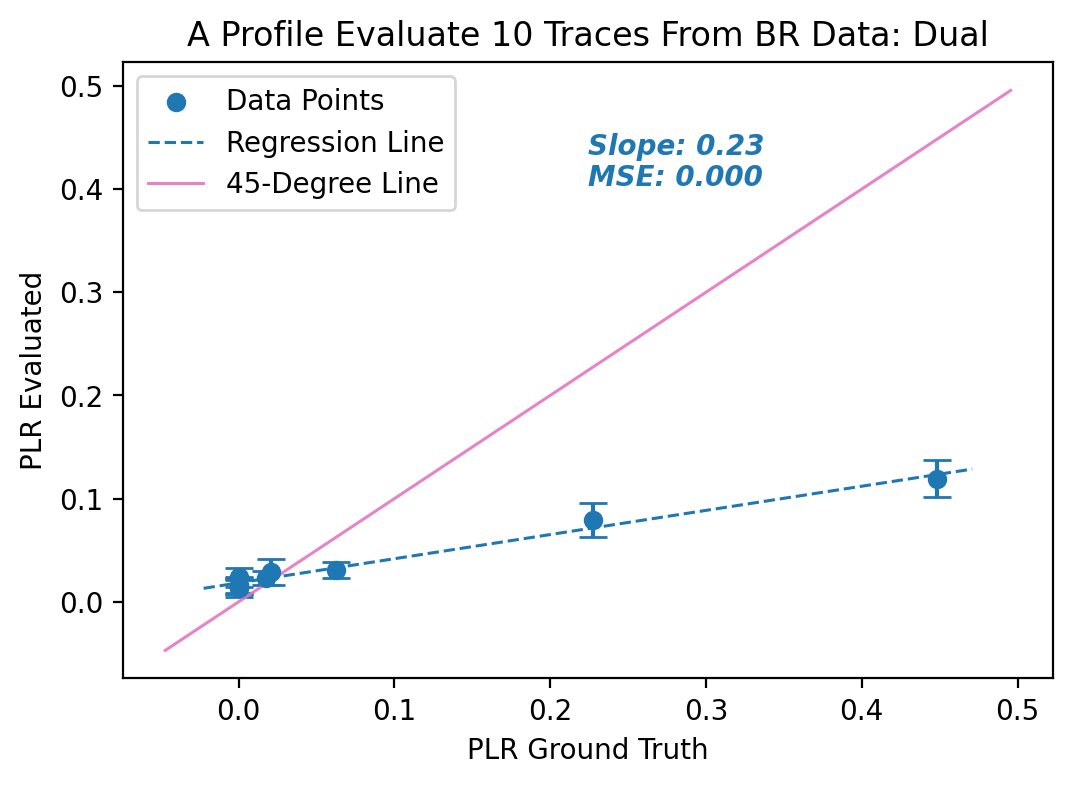

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Sample data
x = LOSS_GT.copy()
y = LOSS_EV.copy()

# Standard deviations for error bars
y_error = LOSS_STD.copy()

# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot with error bars and horizontal caps
ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

# Regression line
coefficients = np.polyfit(x, y, 1)
regression_line = np.poly1d(coefficients)
ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

# Annotate the slope of the regression line
slope_annotation = f'Slope: {coefficients[0]:.2f}'
ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

# Annotate MSE From the regression line
y_pred = regression_line(x)
mse = mean_squared_error(y, y_pred)
slope_annotation = f'MSE: {mse:.3f}'
ax.annotate(slope_annotation, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

# 45-Degree Line
ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)

# Set labels and title
ax.set_xlabel('PLR Ground Truth')
ax.set_ylabel('PLR Evaluated')
ax.set_title('A Profile Evaluate 10 Traces From BR Data: Dual')

# Add a legend
ax.legend()

# Show the plot
plt.show()